**download dataset**

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d nageshsingh/fvc2002-fingerprints

# !mkdir -p "/content/drive/MyDrive/vision/project1/dataset"

# !mv fvc2002-fingerprints.zip "/content/drive/MyDrive/vision/project1/dataset"

# !unzip -q "/content/drive/MyDrive/vision/project1/dataset/fvc2002-fingerprints.zip" -d "/content/drive/MyDrive/vision/project1/dataset"


Dataset URL: https://www.kaggle.com/datasets/nageshsingh/fvc2002-fingerprints
License(s): unknown


**Import Requirements**

In [ ]:
import os
import random
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import torchvision.transforms as transforms
import random
from IPython.display import display, HTML
from sklearn.metrics import f1_score, accuracy_score


**Data preparation**

In [3]:
def load_user_dict_renamed(root_dir):
    user_dict = {}
    user_offset = 0

    folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        image_paths = sorted(glob.glob(os.path.join(folder_path, "*.tif")))

        users_in_folder = sorted(set(os.path.basename(p).split("_")[0] for p in image_paths))
        for i, user in enumerate(users_in_folder):
            new_user_id = str(101 + user_offset + i)
            user_images = [p for p in image_paths if os.path.basename(p).startswith(user + "_")]
            user_dict[new_user_id] = user_images

        user_offset += len(users_in_folder)

    print(f"Number of users: {len(user_dict)}")
    return user_dict


def create_pairs(user_dict, num_negatives_per_positive=4):
    samples = []
    user_ids = list(user_dict.keys())

    for user_id in user_ids:
        images = user_dict[user_id]
        # positive
        for i in range(len(images)):
            for j in range(i + 1, len(images)):
                samples.append((images[i], images[j], 1))

            # negative
            for _ in range(num_negatives_per_positive):
                negative_user_id = np.random.choice([uid for uid in user_ids if uid != user_id])
                negative_image = np.random.choice(user_dict[negative_user_id])
                samples.append((images[i], negative_image, 0))

    return samples


class FingerprintSiameseDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.samples[idx]
        img1 = Image.open(img1_path).convert("L")
        img2 = Image.open(img2_path).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [4]:
dataset_root = '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2002'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
user_dict = load_user_dict_renamed(dataset_root)
samples = create_pairs(user_dict, num_negatives_per_positive=7)
dataset = FingerprintSiameseDataset(samples, transform=transform)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))


Number of users: 40
Number of training samples: 3024
Number of testing samples: 336


Siamese Network and Contrastive Loss



In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size=128):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.resnet18(pretrained=True)

        initial_conv = self.base_model.conv1
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        with torch.no_grad():
            self.base_model.conv1.weight = nn.Parameter(initial_conv.weight.mean(dim=1, keepdim=True))

        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.embedding_layer = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )

    def extract_embedding(self, x):
        x = self.base_model(x)
        x = self.embedding_layer(x)
        return x

    def forward(self, image1, image2):
        emb1 = self.extract_embedding(image1)
        emb2 = self.extract_embedding(image2)
        return emb1, emb2

embedding_size = 128
model = SiameseNetwork(embedding_size=embedding_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


In [6]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, labels):
        euclidean_distance = F.pairwise_distance(output1, output2, p=2)+ 1e-8

        loss_pos = labels * torch.pow(euclidean_distance, 2)
        loss_neg = (1 - labels) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0), 2)
        total_loss = torch.mean(loss_pos + loss_neg)

        return total_loss


loss_criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


**Training**

In [7]:
def train_model(model, criterion, optimizer, train_loader, num_epochs=10, checkpoint_dir="checkpoints", checkpoint_interval=3):
    model.train()
    epoch_losses = []
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        print(f"epoch {epoch+1} started...")
        running_loss = 0.0
        for img1, img2, labels in train_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            emb1, emb2 = model(img1, img2)
            loss = criterion(emb1, emb2, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"fingerprint30_{epoch+1}.pt")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at: {checkpoint_path}")

    return epoch_losses

train_losses = train_model(
    model,
    loss_criterion,
    optimizer,
    train_loader,
    num_epochs=30,
    checkpoint_dir='/content/drive/MyDrive/vision/project1/models/new',
    checkpoint_interval=3
    )


epoch 1 started...
Epoch [1/30], Loss: 0.1878
epoch 2 started...
Epoch [2/30], Loss: 0.0574
epoch 3 started...
Epoch [3/30], Loss: 0.0352
Checkpoint saved at: /content/drive/MyDrive/vision/project1/models/new/fingerprint30_3.pt
epoch 4 started...
Epoch [4/30], Loss: 0.0249
epoch 5 started...
Epoch [5/30], Loss: 0.0212
epoch 6 started...
Epoch [6/30], Loss: 0.0176
Checkpoint saved at: /content/drive/MyDrive/vision/project1/models/new/fingerprint30_6.pt
epoch 7 started...
Epoch [7/30], Loss: 0.0146
epoch 8 started...
Epoch [8/30], Loss: 0.0132
epoch 9 started...
Epoch [9/30], Loss: 0.0115
Checkpoint saved at: /content/drive/MyDrive/vision/project1/models/new/fingerprint30_9.pt
epoch 10 started...
Epoch [10/30], Loss: 0.0103
epoch 11 started...
Epoch [11/30], Loss: 0.0095
epoch 12 started...
Epoch [12/30], Loss: 0.0090
Checkpoint saved at: /content/drive/MyDrive/vision/project1/models/new/fingerprint30_12.pt
epoch 13 started...
Epoch [13/30], Loss: 0.0072
epoch 14 started...
Epoch [14/30]

 **load model**



In [26]:
checkpoint = torch.load('/content/drive/MyDrive/vision/project1/models/new/model_simple_30.pt', map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

**Test**

In [27]:
def test_model(model, data_loader, threshold=0.5):
    model.eval()
    correct_preds = 0
    total_samples = 0
    time_taken_per_pair = []

    with torch.no_grad():
        for image1, image2, target_labels in data_loader:
            image1, image2, target_labels = image1.to(device), image2.to(device), target_labels.to(device)

            start = time.time()

            embeddings1, embeddings2 = model(image1, image2)
            distance = F.pairwise_distance(embeddings1, embeddings2)

            end = time.time()

            batch_size = target_labels.size(0)
            time_per_example = (end - start) / batch_size

            for _ in range(batch_size):
                time_taken_per_pair.append(time_per_example)

            predictions = (distance < threshold).float()
            correct_preds += (predictions == target_labels).sum().item()
            total_samples += batch_size

    accuracy_percent = (correct_preds / total_samples) * 100
    avg_time_per_pair = sum(time_taken_per_pair) / len(time_taken_per_pair) * 1000

    print(f"Test Accuracy: {accuracy_percent:.2f}%")
    print(f"Avg Processing Time per Pair: {avg_time_per_pair:.2f} ms")
    print(f"Total Pairs Evaluated: {len(time_taken_per_pair)}")

    return accuracy_percent, time_taken_per_pair


In [29]:
accuracy, processing_times = test_model(model, test_loader, threshold=0.05)


Test Accuracy: 89.58%
Avg Processing Time per Pair: 0.22 ms
Total Pairs Evaluated: 336


# **infrence**

In [43]:
support_set = {
  0: ['/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/101_1.tif',
        '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/101_2.tif',
        '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/101_5.tif',
        '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/101_7.tif',
        '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/101_6.tif'],

  1: ['/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB3_B_new/102_1.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB3_B_new/102_2.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB3_B_new/102_4.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB3_B_new/102_6.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB3_B_new/102_8.tif'],

  2: ['/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/103_1.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/103_2.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/103_3.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/103_6.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/103_7.tif'],

  3: ['/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB2_B_new/104_1.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB2_B_new/104_6.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB2_B_new/104_4.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB2_B_new/104_5.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB2_B_new/104_3.tif'],

  4: ['/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/106_5.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/106_7.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/106_2.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/106_1.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/106_8.tif'],

   5: ['/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/109_1.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/109_3.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/109_6.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/109_7.tif',
      '/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/109_8.tif']}

query_set = [
    ('/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/101_4.tif',0),
    ('/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB3_B_new/102_5.tif',1),
    ('/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/103_5.tif',2),
    ('/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB2_B_new/104_7.tif',3),
    ('/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/106_4.tif',4),
    ('/content/drive/MyDrive/vision/project1/dataset/fingerprints/FVC2004/DB1_B_new/109_5.tif',5)

 ]

In [44]:
support_images = []
support_labels = []

for label, paths in support_set.items():
    for path in paths:
        support_images.append(path)
        support_labels.append(label)

query_labels = [path for label, path in query_set]
query_images = [label for label, path in query_set]


sampless = create_pairs(support_set, num_negatives_per_positive=4)
support_dataset = FingerprintSiameseDataset(sampless, transform=transform)

support_loader = DataLoader(support_dataset, batch_size=16, shuffle=True)


In [32]:
def preprocess_image(img_path):
    image = Image.open(img_path).convert("L")
    return transform(image).unsqueeze(0).to(device)

In [33]:
SUPPORT_EMB_PATH = "support_embeddings.pt"

In [34]:
def compute_embedding(img_path):
    image_tensor = preprocess_image(img_path)
    with torch.no_grad():
        embedding = model.extract_embedding(image_tensor)
        embedding = F.normalize(embedding, p=2, dim=1)

    return embedding


def compute_support_embeddings(support_set, force_recompute=False):
    if os.path.exists(SUPPORT_EMB_PATH) and not force_recompute:
        print("Loading cached support embeddings...")
        return torch.load(SUPPORT_EMB_PATH)

    print("Computing support embeddings...")
    support_embeddings = {}
    for label, img_paths in support_set.items():
        embs = [compute_embedding(p) for p in img_paths]
        support_embeddings[label] = torch.stack(embs).mean(dim=0)

    torch.save(support_embeddings, SUPPORT_EMB_PATH)
    print("Support embeddings cached.")
    return support_embeddings

In [60]:
def euclidean_distance(tensor1, tensor2):
    return F.pairwise_distance(tensor1, tensor2)


def predict_query_labels(support_set, query_set, threshold=0.7):
    predictions = []
    support_embeddings = compute_support_embeddings(support_set)

    total_time = 0
    query_times = []
    for query_path, true_label in query_set:
        start_time = time.time()
        query_emb = compute_embedding(query_path)
        distances = {
            label: euclidean_distance(query_emb, emb).item()
            for label, emb in support_embeddings.items()
        }

        min_label, min_distance = min(distances.items(), key=lambda x: x[1])
        if min_distance < threshold:
            predicted_label = min_label
        else:
            predicted_label = -1

        end_time = time.time()
        response_time = end_time - start_time
        total_time += response_time
        query_times.append(response_time)

        predictions.append((query_path, true_label, predicted_label, min_distance))

    avg_time = total_time / len(query_set)
    return predictions, avg_time ,query_times


In [ ]:
def find_best_threshold(support_set, query_set, thresholds=None):
    if thresholds is None:
        thresholds = [i / 100 for i in range(10, 100, 5)]  # 0.10, 0.15, ..., 0.95

    best_threshold = None
    best_score = -1
    all_scores = []

    for thresh in thresholds:
        predictions, _ ,_ = predict_query_labels(support_set, query_set, threshold=thresh)

        y_true = []
        y_pred = []
        for _, true_label, pred_label, _ in predictions:
            y_true.append(true_label)
            y_pred.append(pred_label)

        if -1 in y_pred:
            score = f1_score(y_true, y_pred, average='macro', zero_division=0)
        else:
            score = f1_score(y_true, y_pred, average='macro')

        all_scores.append((thresh, score))

        if score > best_score:
            best_score = score
            best_threshold = thresh

    print("All thresholds and scores:")
    for t, s in all_scores:
        print(f"Threshold: {t:.2f} -> F1 Score: {s:.4f}")

    print(f"\nBest threshold: {best_threshold:.2f} with F1 Score: {best_score:.4f}")
    return best_threshold

best_thresh = find_best_threshold(support_set, query_set)

Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
Loading cached support embeddings...
All thresholds and scores:
Threshold: 0.10 -> F1 Score: 0.4286
Threshold: 0.15 -> F1 Score: 0.5714
Threshold: 0.20 -> F1 Score: 0.7143
Threshold: 0.25 -> F1 Score: 0.7143
Threshold: 0.30 -> F1 Score: 0.7143
Threshold: 0.35 -> F1 Score: 0.7778
Threshold: 0.40 -> F1 Score: 0.7778
Threshold: 0.45 -> F1 Score: 0.7778
Threshold: 0.50 -> 

In [62]:
results, avg_inference_time , query_times = predict_query_labels(support_set, query_set)

display(HTML(f"<b>Average Query Time:</b> {avg_inference_time * 1000:.2f} ms<br><br>"))

correct = 0
html_output = ""

for img_path, true, pred, dist in results:
    if true == pred:
        html_output += f"<div style='color:green;'>✅ True: {true} | Pred: {pred} | Distance: {dist:.4f} | Path: {img_path}</div>"
        correct += 1
    else:
        html_output += f"<div style='color:red;'>❌ True: {true} | Pred: {pred} | Distance: {dist:.4f} | Path: {img_path}</div>"

accuracy = correct / len(results) * 100
html_output += f"<br><div style='color:cyan;'><b>Final Accuracy:</b> {accuracy:.2f}% ({correct}/{len(results)})</div>"

display(HTML(html_output))


Loading cached support embeddings...


Loading cached support embeddings...


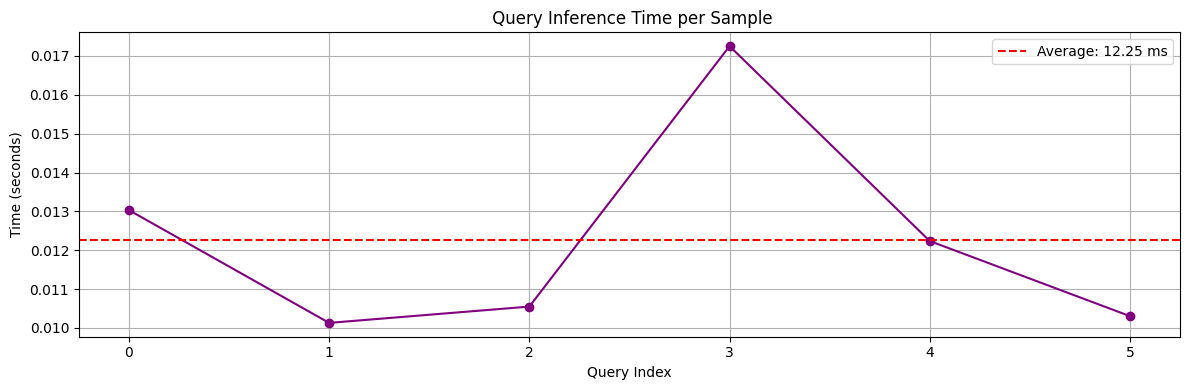

In [65]:
results, avg_time, query_times = predict_query_labels(support_set, query_set)

plt.figure(figsize=(12, 4))
plt.plot(query_times, marker='o', linestyle='-', color='purple')
plt.axhline(y=avg_time, color='red', linestyle='--', label=f'Average: {avg_time*1000:.2f} ms')
plt.legend()
plt.title(" Query Inference Time per Sample")
plt.xlabel("Query Index")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()


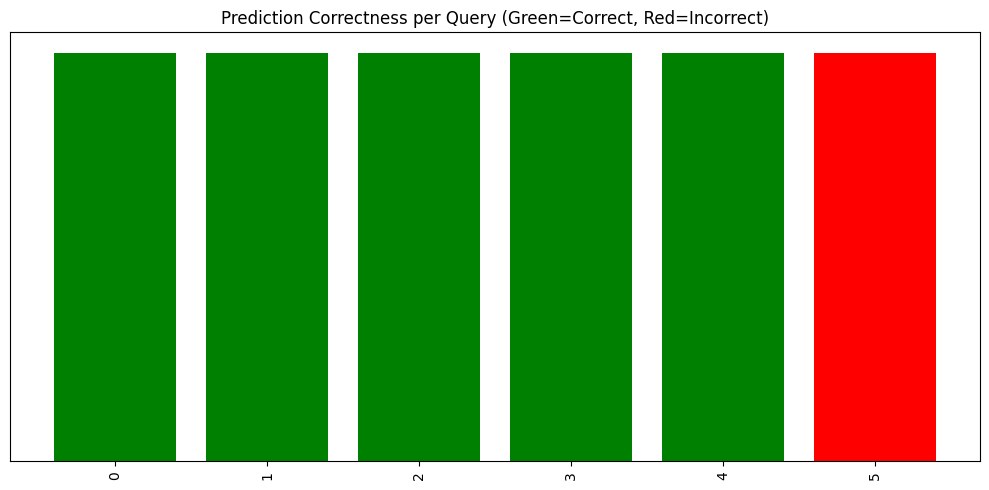

In [59]:

labels = []
colors = []

for i, (img_path, true, pred, dist) in enumerate(results):
    is_correct = true == pred
    labels.append(f"{i}")
    colors.append('green' if is_correct else 'red')

# رسم نمودار
plt.figure(figsize=(10,5))
plt.bar(labels, [1]*len(labels), color=colors)
plt.xticks(rotation=90)
plt.yticks([])
plt.title("Prediction Correctness per Query (Green=Correct, Red=Incorrect)")
plt.tight_layout()
plt.show()
